In [1]:
"""
Boltzmann Machine Implementation for Probablistic learning.
A fully-connected recurrent neural network with visible and hidden units that learns pattern distributions.
"""
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [2]:
# Configuration (aligned with Hopfield notebook)
IMAGE_CROP = 2              # crop margin per side (28 -> 28-2*IMAGE_CROP)
DIGITS = [3]                # list of digits to learn from (e.g. [0,1,8])
N_TRAIN = 20                # number of images to sample from the selected digits

# Load and preprocess MNIST
(X_train, y_train), _ = mnist.load_data()
X_train = X_train[:, IMAGE_CROP:-IMAGE_CROP, IMAGE_CROP:-IMAGE_CROP].astype('float32') / 255.0
IMAGE_SIZE = X_train.shape[1]

# Select and sample images for the requested digits
candidate_idx = np.where(np.isin(y_train, DIGITS))[0]
sel_pos = np.random.choice(candidate_idx.size, size=min(N_TRAIN, candidate_idx.size), replace=False)
selected_idx = candidate_idx[sel_pos]
selected_images = X_train[selected_idx]
selected_labels = y_train[selected_idx]

# Binarize by per-image mean and set training patterns
image_means = selected_images.mean(axis=(1,2), keepdims=True)
training_patterns = (selected_images > image_means).astype(np.float32)

print(f"Selected {training_patterns.shape[0]} images for digits {DIGITS}")
print(f"Visible units per sample: {IMAGE_SIZE}x{IMAGE_SIZE} = {IMAGE_SIZE**2}")

Selected 20 images for digits [3]
Visible units per sample: 24x24 = 576


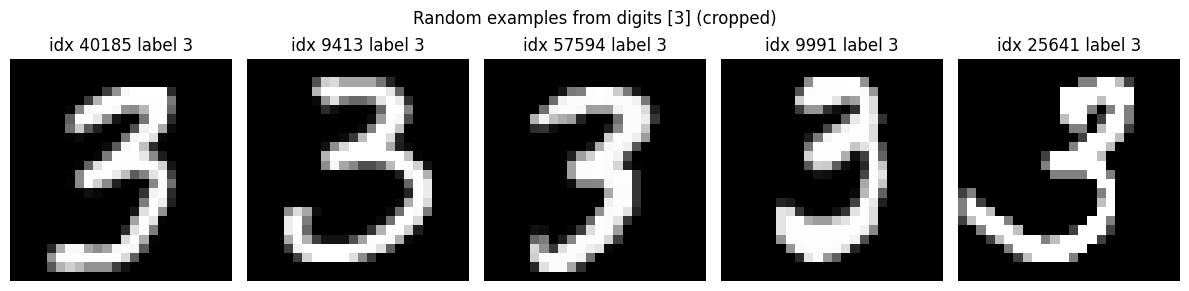

In [3]:
# Visualize random up-to-5 examples from the selected training set (grayscale)
viz_rng = np.random.default_rng(43)
sel = viz_rng.choice(N_TRAIN, size=5, replace=False)
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i, idx in enumerate(sel):
    axes[i].imshow(selected_images[idx], cmap='gray', interpolation='nearest')
    axes[i].set_title(f"idx {selected_idx[idx]} label {selected_labels[idx]}")
    axes[i].axis('off')
plt.suptitle(f"Random examples from digits {DIGITS} (cropped)")
plt.tight_layout()
plt.show()

In [4]:
class Neuron:
    """
    Simple neuron wrapper for Boltzmann Machine units.
    Visible units use states {0,1}. Hidden units also use {0,1}.
    """
    def __init__(self, index, is_visible=True, bias=0.0):
        self.index = index
        self.is_visible = is_visible
        self.bias = float(bias)
        # State stored as 0.0 or 1.0 (float) for vector math compatibility
        self.state = float(np.random.rand() < 0.5)

    def logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def sample_state(self, input_sum):
        """
        Probabilistically sample state given input_sum (bias included externally).
        Returns 1.0 or 0.0
        """
        p = self.logistic(input_sum)
        self.state = 1.0 if np.random.rand() < p else 0.0
        return self.state

In [5]:
class BoltzmannMachine:
    """
    Small fully-connected Boltzmann Machine (visible + hidden).
    Implementation uses Gibbs sampling and contrastive divergence-like updates
    (one-step free phase here for simplicity).
    """
    def __init__(self, n_visible, n_hidden, rng=None):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_units = n_visible + n_hidden
        self.rng = np.random.default_rng() if rng is None else rng

        # Weight matrix initialized small (symmetric, zero diag)
        self.W = self.rng.normal(0, 0.01, (self.n_units, self.n_units))
        self.W = (self.W + self.W.T) / 2.0
        np.fill_diagonal(self.W, 0.0)

        # Bias for each unit (visible + hidden)
        self.bias = np.zeros(self.n_units, dtype=np.float32)

        # Create neuron wrappers
        self.neurons = []
        for i in range(n_visible):
            self.neurons.append(Neuron(i, is_visible=True, bias=self.bias[i]))
        for j in range(n_hidden):
            idx = n_visible + j
            self.neurons.append(Neuron(idx, is_visible=False, bias=self.bias[idx]))

        self.persistent_states = np.array([n.state for n in self.neurons], dtype=np.float32)

    def _unit_input(self, i):
        """Return total input to unit i (W row dot states + bias)."""
        states = np.array([n.state for n in self.neurons], dtype=np.float32)
        return float(self.W[i].dot(states) + self.bias[i])

    def sample_unit(self, i):
        input_sum = self._unit_input(i)
        return self.neurons[i].sample_state(input_sum)

    def gibbs_step(self):
        """Perform one full Gibbs sweep over all units in random order."""
        order = self.rng.permutation(self.n_units)
        for i in order:
            self.sample_unit(i)

    def run_clamped_phase(self, data, hidden_steps=50):
        """
        Clamp visible units to data (0/1) and sample hidden units to estimate positive phase correlations.
        Returns outer product <s_i s_j>_data
        """
        # clamp visible units
        for i in range(self.n_visible):
            self.neurons[i].state = float(data[i])

        # initialize hidden randomly then Gibbs-sample hidden units (visible remain clamped)
        for _ in range(hidden_steps):
            for j in range(self.n_visible, self.n_units):
                self.sample_unit(j)

        s = np.array([n.state for n in self.neurons], dtype=np.float32)
        return np.outer(s, s), s

    def run_free_phase(self, free_steps=200):
        """Run Gibbs sampling without clamping and return correlations <s_i s_j>_model."""
        # initialize neurons with persistent state, not random
        for i, n in enumerate(self.neurons):
            n.state = float(self.persistent_states[i])

        for _ in range(free_steps):
            self.gibbs_step()

        s = np.array([n.state for n in self.neurons], dtype=np.float32)
        self.persistent_states = s.copy()
        return np.outer(s, s), s

    def train_step(self, data, lr=0.01, hidden_steps=50, free_steps=200):
        """Single contrastive-like update using clamped and free phases."""
        pos_corr, pos_states = self.run_clamped_phase(data, hidden_steps=hidden_steps)
        neg_corr, neg_states = self.run_free_phase(free_steps=free_steps)

        # weight update (symmetric), and bias updates for units
        self.W += lr * (pos_corr - neg_corr)
        self.W = (self.W + self.W.T) / 2.0
        np.fill_diagonal(self.W, 0.0)

        # biases: difference between positive and negative state means
        self.bias += lr * (pos_states - neg_states)

    def free_sample_visible(self, steps=500):
        """Return a sampled visible vector after running free Gibbs sampling."""
        self.run_free_phase(free_steps=steps)
        vis = np.array([n.state for n in self.neurons[:self.n_visible]], dtype=np.float32)
        return vis

In [6]:
# Initialize and train the Boltzmann machine
n_visible = IMAGE_SIZE * IMAGE_SIZE
n_hidden = 50   # small hidden layer for demonstration (tune as needed)
bm = BoltzmannMachine(n_visible=n_visible, n_hidden=n_hidden)

n_epochs = 20
lr = 0.01

# Prepare data: flatten selected training patterns to vectors of 0/1
flat_patterns = training_patterns.reshape(N_TRAIN, -1).astype(np.float32)

for epoch in range(n_epochs):
    for data in flat_patterns:
        bm.train_step(data, lr=lr, hidden_steps=20, free_steps=100)
    print(f"Epoch {epoch+1}/{n_epochs} complete (trained on {flat_patterns.shape[0]} samples)")

print('Training complete')

Epoch 1/20 complete (trained on 20 samples)
Epoch 2/20 complete (trained on 20 samples)
Epoch 2/20 complete (trained on 20 samples)
Epoch 3/20 complete (trained on 20 samples)
Epoch 3/20 complete (trained on 20 samples)
Epoch 4/20 complete (trained on 20 samples)
Epoch 4/20 complete (trained on 20 samples)
Epoch 5/20 complete (trained on 20 samples)
Epoch 5/20 complete (trained on 20 samples)
Epoch 6/20 complete (trained on 20 samples)
Epoch 6/20 complete (trained on 20 samples)
Epoch 7/20 complete (trained on 20 samples)
Epoch 7/20 complete (trained on 20 samples)
Epoch 8/20 complete (trained on 20 samples)
Epoch 8/20 complete (trained on 20 samples)
Epoch 9/20 complete (trained on 20 samples)
Epoch 9/20 complete (trained on 20 samples)
Epoch 10/20 complete (trained on 20 samples)
Epoch 10/20 complete (trained on 20 samples)
Epoch 11/20 complete (trained on 20 samples)
Epoch 11/20 complete (trained on 20 samples)
Epoch 12/20 complete (trained on 20 samples)
Epoch 12/20 complete (train

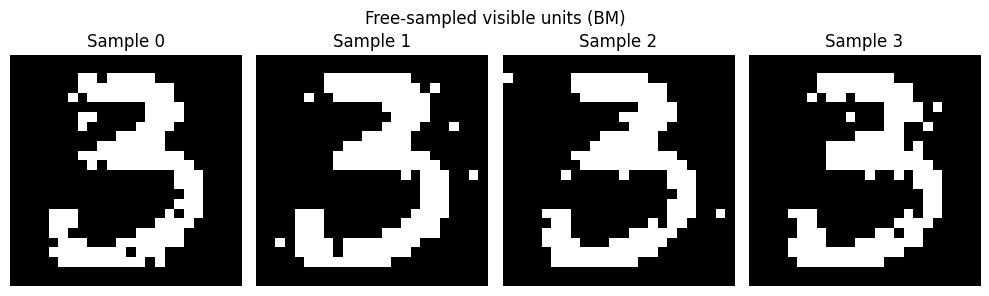

In [7]:
# Sample from the model (free sampling) and visualize a few generated images
n_samples_to_show = min(4, N_TRAIN)
fig, axes = plt.subplots(1, n_samples_to_show, figsize=(10, 3))
for i in range(n_samples_to_show):
    vis = bm.free_sample_visible(steps=300)
    img = vis.reshape(IMAGE_SIZE, IMAGE_SIZE)
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Sample {i}")
plt.suptitle('Free-sampled visible units (BM)')
plt.tight_layout()
plt.show()